In [116]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
def allen_cahn_drift(u, dx, eps):
    """
    Compute Allen-Cahn drift with Neumann boundary conditions: u_x(±1) = 0
    """
    # Interior points: central difference
    u_xx_interior = (torch.roll(u, -1) - 2*u + torch.roll(u, 1)) / (dx*dx)
    
    # Apply Neumann boundary conditions: u_x = 0 at boundaries
    u_xx = u_xx_interior.clone()
    
    # At left boundary (x=-1): use forward difference approximation
    # u_x = 0 implies u[0] = u[1] for discrete approximation
    u_xx[..., 0] = (2*u[..., 1] - 2*u[..., 0]) / (dx*dx)
    
    # At right boundary (x=1): use backward difference approximation  
    # u_x = 0 implies u[-1] = u[-2] for discrete approximation
    u_xx[..., -1] = (2*u[..., -2] - 2*u[..., -1]) / (dx*dx)
    
    reaction = -(1/eps**2) * (u**3 - u)
    return u_xx + reaction

In [118]:
def simulate_allen_cahn(u0: torch.Tensor, dx: float, eps: float,
                        T: float = 1.0, dt: float = 1e-4):
    """
    Evolve Allen–Cahn equation from t=0 to t=T.
    u0: shape (dim,)
    returns: final state u(T)
    """
    steps = int(T / dt)
    u = u0.clone()

    for _ in range(steps):
        du = allen_cahn_drift(u, dx, eps)
        u = u + dt * du  # Euler step

    return u


In [119]:
def generate_ICs_variable_n(x, n_min=1, n_max=10):
    """
    Generates a single initial condition u0(x) using:
        u0(x) = sin(pi/n * x) * x^2 * (1 - x)^2
    where n is randomly chosen between n_min and n_max.
    """
    n = torch.randint(n_min, n_max + 1, (1,)).item()
    amp = torch.rand(1).item() * 1.5 + 0.5  # between 0.5 and 2
    u0 = amp * torch.sin((math.pi / n) * x)

    return u0


In [120]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @property
    @abstractmethod
    def dim(self) -> int:
        """
        Returns:
            - Dimensionality of the distribution
        """
        pass
        
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, dim)
        """
        pass

class Density(ABC):
    """
    Distribution with tractable density
    """
    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the log density at x.
        Args:
            - x: shape (batch_size, dim)
        Returns:
            - log_density: shape (batch_size, 1)
        """
        pass

class Gaussian(torch.nn.Module, Sampleable, Density):
    """
    Multivariate Gaussian distribution
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        """
        mean: shape (dim,)
        cov: shape (dim,dim)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def dim(self) -> int:
        return self.mean.shape[0]

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))
        
    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

    @classmethod
    def isotropic(cls, dim: int, std: float) -> "Gaussian":
        mean = torch.zeros(dim)
        cov = torch.eye(dim) * std ** 2
        return cls(mean, cov)


class AllenCahnDataset(torch.nn.Module, Sampleable):
    """
    Empirical distribution of Allen–Cahn final fields
    using variable initial conditions and many epsilons.
    """
    def __init__(
        self,
        N: int,
        eps_min: float,
        eps_max: float,
        num_epsilons: int,
        T: float = 10.0,
        dt: float = 1e-3,
        device=device,
        n_min=1,
        n_max=2
    ):
        super().__init__()
        self.N = N
        self.device = device

        # spatial grid
        x = torch.linspace(-1, 1, N, device=device)
        self.dx = (x[1] - x[0]).item()
        self.x = x

        # epsilon values
        self.epsilons = torch.logspace(
            math.log10(eps_min),
            math.log10(eps_max),
            steps=num_epsilons,
            device=device
        )

        # time discretization
        num_steps = int(T / dt)
        ts = torch.linspace(0, T, num_steps + 1, device=device).view(1, -1, 1)

        samples = []
        print("Generating Allen–Cahn dataset...")

        for eps in tqdm(self.epsilons):
            # --- variable IC
            u0 = generate_ICs_variable_n(x, n_min, n_max).unsqueeze(0)

            # --- build ODE
            ode = AllenCahnODE(self.dx, eps.item())

            # --- simulate
            simulator = EulerSimulator(ode)
            uT = simulator.simulate(u0, ts)  # shape (1, N)

            samples.append(uT.squeeze(0))

        self.register_buffer("data", torch.stack(samples, dim=0))


    # ---- Sampleable interface ----
    @property
    def dim(self) -> int:
        return self.N

    def sample(self, num_samples: int) -> torch.Tensor:
        idx = torch.randint(0, self.data.shape[0], (num_samples,), device=self.device)
        return self.data[idx]


In [121]:
# Several plotting utility functions
def hist2d_samples(samples, ax: Optional[Axes] = None, bins: int = 200, scale: float = 5.0, percentile: int = 99, **kwargs):
    H, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=bins, range=[[-scale, scale], [-scale, scale]])
    
    # Determine color normalization based on the 99th percentile
    cmax = np.percentile(H, percentile)
    cmin = 0.0
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    # Plot using imshow for more control
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(H.T, extent=extent, origin='lower', norm=norm, **kwargs)

def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, bins=200, scale: float = 5.0, percentile: int = 99, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples).detach().cpu() # (ns, 2)
    hist2d_samples(samples, ax, bins, scale, percentile, **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def kdeplot_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    sns.kdeplot(x=samples[:,0].cpu(), y=samples[:,1].cpu(), ax=ax, **kwargs)

def imshow_density(density: Density, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float], bins: int, ax: Optional[Axes] = None, x_offset: float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    x = torch.linspace(x_min, x_max, bins).to(device) + x_offset
    y = torch.linspace(y_min, y_max, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent=[x_min, x_max, y_min, y_max], origin='lower', **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, x_offset:float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale + x_offset, scale + x_offset, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), origin='lower', **kwargs)

In [122]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (batch_size, 1)
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass


class AllenCahnODE(ODE):
    """
    ODE class implementing du/dt = Allen–Cahn drift with fixed dx and epsilon.
    """
    def __init__(self, dx: float, eps: float):
        super().__init__()
        self.dx = dx
        self.eps = eps

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # xt: (bs, dim)
        # t: (bs, 1) but unused in AC equation
        return allen_cahn_drift(xt, self.dx, self.eps)


In [123]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (bs,1)
            - dt: time, shape (bs,1)
        Returns:
            - nxt: state at time t + dt (bs, dim)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (bs, num_timesteps,1)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (bs, num_timesteps, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num
            _timesteps, dim)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.ode.drift_coefficient(xt,t) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.sde.drift_coefficient(xt,t) * h + self.sde.diffusion_coefficient(xt,t) * torch.sqrt(h) * torch.randn_like(xt)

def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

In [124]:
class ConditionalProbabilityPath(torch.nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, dim)
        """
        num_samples = t.shape[0]
        # Sample conditioning variable z ~ p(z)
        z = self.sample_conditioning_variable(num_samples) # (num_samples, dim)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, dim)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        pass
    
    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        pass
        
    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """ 
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_score: conditional score (num_samples, dim)
        """ 
        pass

Generating Allen–Cahn dataset...


100%|██████████| 200/200 [00:00<00:00, 13570.29it/s]


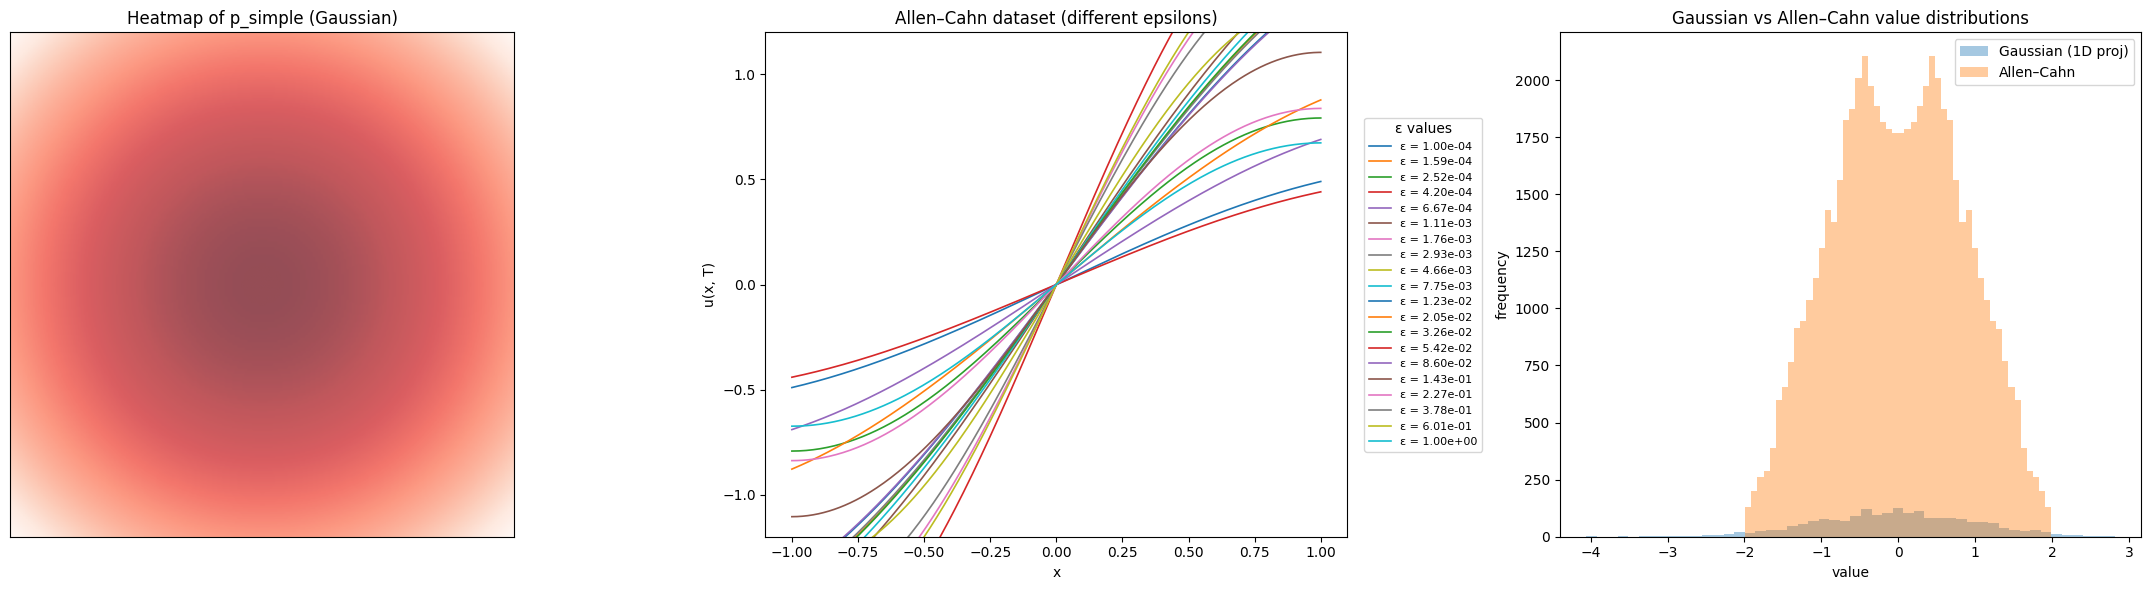

In [125]:
# ---- p_simple (2D Gaussian) ----
p_simple = Gaussian.isotropic(dim=2, std=1.0).to(device)

# ---- p_data (Allen–Cahn dataset) ----
p_data = AllenCahnDataset(
    N=300,
    eps_min=1e-4,
    eps_max=1,
    num_epsilons=200,
    T=100.0,
    dt=1e-4,
    device=device,
    n_min=2,
    n_max=3
).to(device)

# ---- Plotting ----
fig, axes = plt.subplots(1, 3, figsize=(22, 6))


# ======================================================
# (1) Heatmap of the p_simple Gaussian
# ======================================================
axes[0].set_title("Heatmap of p_simple (Gaussian)")
axes[0].set_xticks([])
axes[0].set_yticks([])

imshow_density(
    density=p_simple,
    x_bounds=(-5, 5),
    y_bounds=(-5, 5),
    bins=200,
    ax=axes[0],
    alpha=0.7,
    cmap="Reds"
)


# ======================================================
# (2) Grid of Allen–Cahn final states for many epsilons
# ======================================================
axes[1].set_title("Allen–Cahn dataset (different epsilons)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("u(x, T)")

x = p_data.x.cpu()
samples = p_data.data.cpu()
eps_vals = p_data.epsilons.cpu()

# plot ~20 curves evenly spaced across epsilons
idxs = torch.linspace(0, samples.shape[0]-1, 20).long()

for idx in idxs:
    axes[1].plot(
        x,
        samples[idx],
        linewidth=1.2,
        label=f"ε = {eps_vals[idx]:.2e}"
    )

axes[1].legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=8,
    title="ε values"
)

axes[1].set_ylim(-1.2, 1.2)


# ======================================================
# (3) Histogram comparison
# ======================================================
axes[2].set_title("Gaussian vs Allen–Cahn value distributions")
axes[2].set_xlabel("value")
axes[2].set_ylabel("frequency")

# Gaussian projection to 1D just for visualization
g = p_simple.sample(2000).cpu()
axes[2].hist(g[:, 0].numpy(), bins=50, alpha=0.4, label="Gaussian (1D proj)")

# All AC values flattened
ac_flat = samples.flatten().numpy()
axes[2].hist(ac_flat, bins=50, alpha=0.4, label="Allen–Cahn")

axes[2].legend()
plt.tight_layout()
plt.show()


In [126]:
class Alpha(ABC):
    def __init__(self):
        # Check alpha_t(0) = 0
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.zeros(1,1)
        )
        # Check alpha_1 = 1
        assert torch.allclose(
            self(torch.ones(1,1)), torch.ones(1,1)
        )
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - alpha_t (num_samples, 1)
        """ 
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """ 
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = vmap(jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)
    
class Beta(ABC):
    def __init__(self):
        # Check beta_0 = 1
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.ones(1,1)
        )
        # Check beta_1 = 0
        assert torch.allclose(
            self(torch.ones(1,1)), torch.zeros(1,1)
        )
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """ 
        pass 

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt beta_t (num_samples, 1)
        """ 
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = vmap(jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)

In [127]:
class LinearAlpha(Alpha):
    """Implements alpha_t = t"""

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return t

        
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """ 
        return torch.ones_like(t)

class SquareRootBeta(Beta):
    """Implements beta_t = sqrt(1 - t)"""

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # ensure numerical stability for t > 1 due to FP errors
        return torch.sqrt(torch.clamp(1 - t, min=0.0))

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return -0.5 / torch.sqrt(torch.clamp(1 - t, min=1e-8))

In [ ]:
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, alpha: Alpha, beta: Beta):
        p_simple = Gaussian.isotropic(p_data.dim, 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z ~ p_data(x)
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        return self.p_data.sample(num_samples)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_t = self.alpha(t)          # (bs, 1)
        beta_t  = self.beta(t)           # (bs, 1)

        eps = torch.randn_like(z)        # (bs, dim)

        return alpha_t * z + beta_t * eps
        
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_t = self.alpha(t)          # (bs, 1)
        beta_t  = self.beta(t)           # (bs, 1)
        beta_safe = beta_t.clamp(min=0.1)
        dalpha  = self.alpha.dt(t)       # (bs, 1)
        dbeta   = self.beta.dt(t)        # (bs, 1)
        dbeta_safe = dbeta.clamp(min=-10, max=10)


        term1 = dalpha * z
        term2 = dbeta_safe * (x - alpha_t*z) / beta_safe

        return term1 + term2

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Score of p_t(x|z) = N(alpha_t z, beta_t^2 I).
        ∇_x log p_t(x|z) = -(x - α_t z) / β_t^2
        """
        alpha_t = self.alpha(t)        # (bs,1)
        beta_t  = self.beta(t)         # (bs,1)

        mean = alpha_t * z             # (bs, dim)
        var  = (beta_t ** 2)           # (bs,1)

        return -(x - mean) / (var + 1e-8)

 

In [129]:
class EmpiricalLatent(Sampleable):
    def __init__(self, Z):
        super().__init__()
        self.Z = Z

    @property
    def dim(self):
        return self.Z.shape[1]

    def sample(self, n):
        idx = torch.randint(0, self.Z.shape[0], (n,))
        return self.Z[idx]

    def log_density(self, x):
        raise NotImplementedError("Not required for visualization.")


Generating Allen–Cahn dataset...


100%|██████████| 50/50 [00:00<00:00, 5503.18it/s]


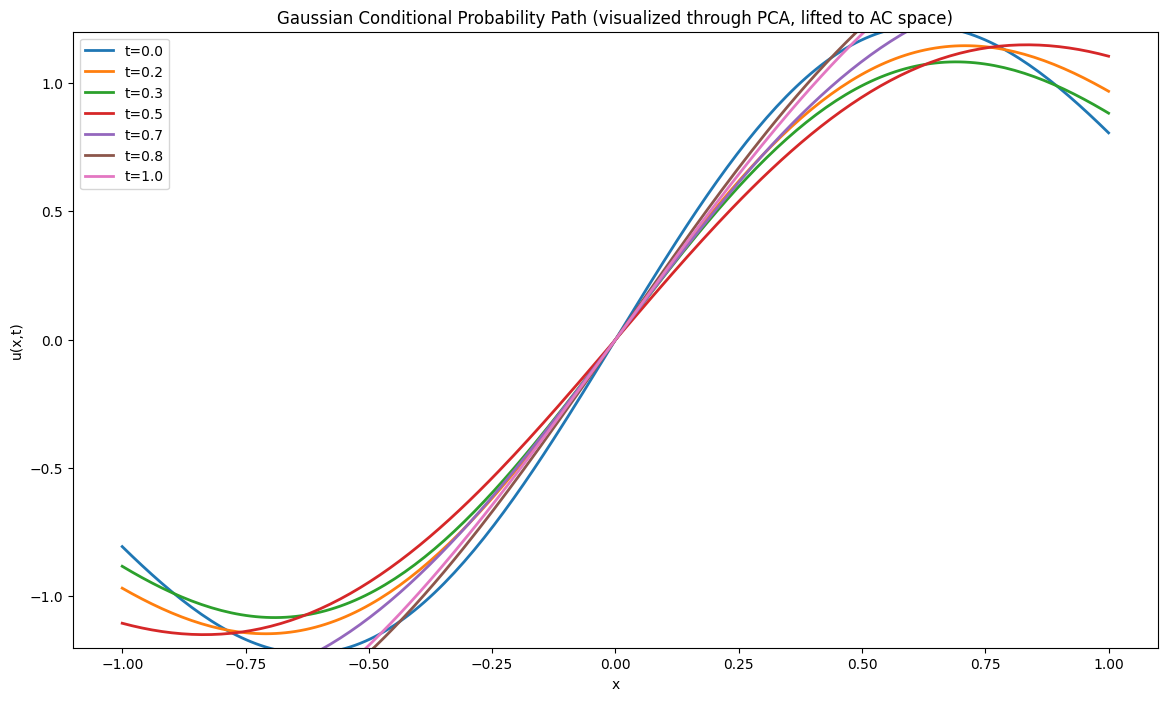

In [130]:
# =============================================
# 1. Build Allen–Cahn p_data (REAL target)
# =============================================
p_data = AllenCahnDataset(
    N=200,
    eps_min=1e-4,
    eps_max=1.0,
    num_epsilons=50,
    T=20.0,
    dt=1e-4,
    device=device
).to(device)

X = p_data.data.cpu().numpy()      # shape (50, 200)

# =============================================
# 2. PCA for visualization only
# =============================================
latent_dim = 2
pca = PCA(n_components=latent_dim)
Z = pca.fit_transform(X)           # shape (50, 2)

Z_torch = torch.from_numpy(Z).float().to(device)

# Empirical distribution wrapper in 2D
p_data_latent = EmpiricalLatent(Z_torch)

# Conditional path in PCA latent space
path_latent = GaussianConditionalProbabilityPath(
    p_data = p_data_latent,
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

p_simple = Gaussian.isotropic(dim=latent_dim, std=1.0).to(device)


# =============================================
# 3. Sample one latent conditioning vector z
# =============================================
z_latent = path_latent.sample_conditioning_variable(1)  # (1,2)
ts = torch.linspace(0.0, 1.0, 7).to(device)

xgrid = p_data.x.cpu()      # spatial grid (200,)
curves = []


# =============================================
# 4. Sample the conditional path in PCA → lift to AC
# =============================================
for t in ts:
    xt_latent = path_latent.sample_conditional_path(
        z_latent.expand(1, -1),
        t.view(1,1)
    )  # (1,2)

    xt_full = pca.inverse_transform(xt_latent.cpu().numpy())   # (1,200)
    curves.append(xt_full[0])


# =============================================
# 5. Plot lifted AC curves
# =============================================
plt.figure(figsize=(14,8))
plt.title("Gaussian Conditional Probability Path (visualized through PCA, lifted to AC space)")
plt.xlabel("x")
plt.ylabel("u(x,t)")

for i, t in enumerate(ts):
    plt.plot(xgrid, curves[i], linewidth=2, label=f"t={t.item():.1f}")

plt.ylim(-1.2, 1.2)
plt.legend()
plt.show()


In [131]:
class ConditionalVectorFieldODE(ODE):
    def __init__(self, path: ConditionalProbabilityPath, z: torch.Tensor):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.path = path
        self.z = z

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t)

Generating Allen–Cahn dataset...


100%|██████████| 999/999 [00:00<00:00, 4761.74it/s]


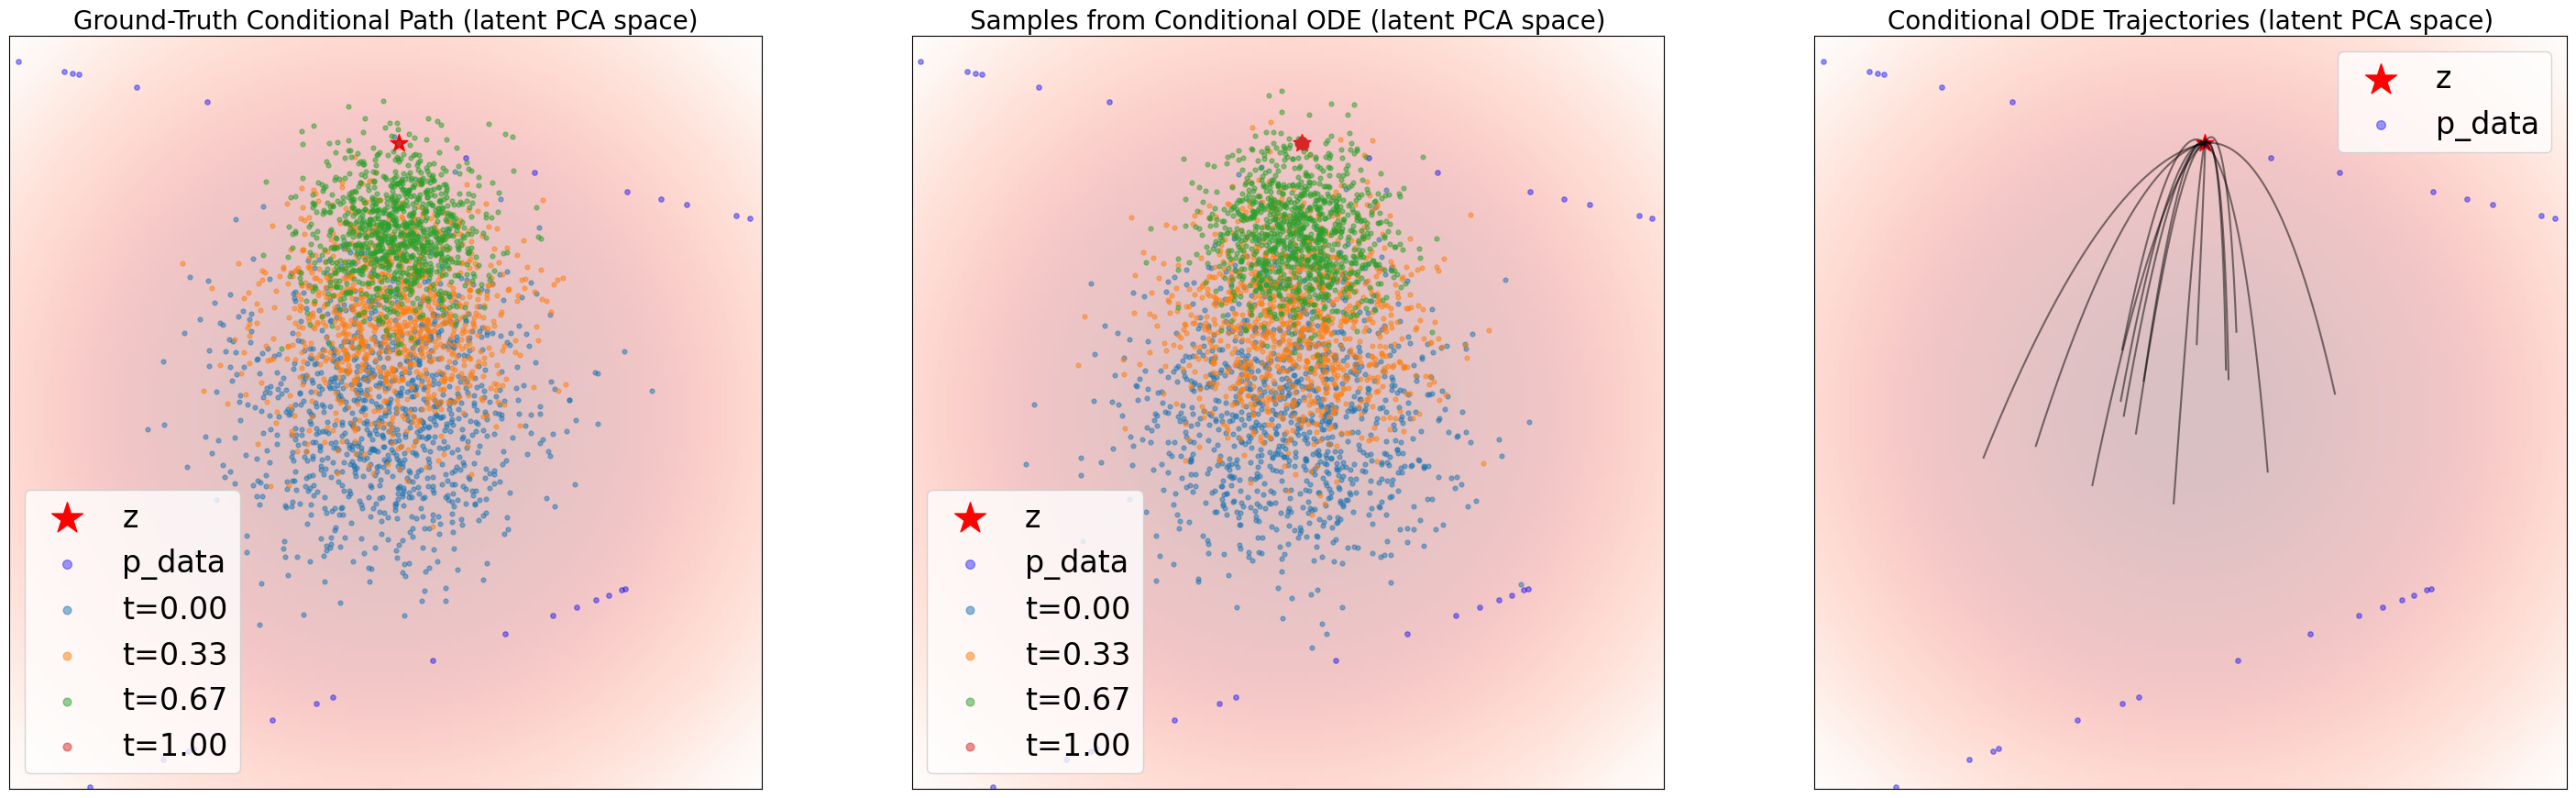

In [132]:
###############################################
# 0. Build Allen–Cahn p_data and PCA to 2D
###############################################
p_data = AllenCahnDataset(
    N=200,
    eps_min=1e-4,
    eps_max=1.0,
    num_epsilons=50,
    T=20.0,
    dt=1e-4,
    device=device
).to(device)

X = p_data.data.cpu().numpy()       # (50, 200)

# PCA to 2D
pca = PCA(n_components=2)
Z = pca.fit_transform(X)            # (50, 2)
Z_torch = torch.from_numpy(Z).float().to(device)

# Empirical 2D p_data for visualization
p_data_latent = EmpiricalLatent(Z_torch)

# Simple Gaussian prior in 2D
p_simple = Gaussian.isotropic(dim=2, std=1.0).to(device)


###############################################
# 1. Build Gaussian Conditional Path in 2D
###############################################
path = GaussianConditionalProbabilityPath(
    p_data=p_data_latent,
    alpha=LinearAlpha(),
    beta=SquareRootBeta()
).to(device)


###############################################
# 2. Setup visualization parameters
###############################################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3

fig, axes = plt.subplots(1,3, figsize=(36, 12))

x_bounds = [-5, 5]
y_bounds = [-5, 5]
legend_size = 24
markerscale = 1.8


###############################################
# 3. Sample conditioning variable z
###############################################
torch.cuda.manual_seed(1)
z = path.sample_conditioning_variable(1)    # (1,2)


############################################################
# 4. CONDITIONAL ODE IN LATENT (PCA) SPACE
############################################################
ode = ConditionalVectorFieldODE(path, z)
simulator = EulerSimulator(ode)

# Initial x(0) ~ p_simple
x0 = p_simple.sample(num_samples)      # (num_samples, 2)

ts = (torch.linspace(0.0, 1.0, num_timesteps)
      .view(1,-1,1)
      .expand(num_samples,-1,1)
      .to(device))

xts = simulator.simulate_with_trajectory(x0, ts)   # (bs, nts, 2)


############################################################
# 5. Middle plot — Samples from ODE at several t
############################################################
ax = axes[1]
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Samples from Conditional ODE (latent PCA space)", fontsize=20)

# Plot z
ax.scatter(z[:,0].cpu(), z[:,1].cpu(),
           marker='*', color='red', s=200, label='z')

# Plot p_simple and p_data (in latent space)
# Plot p_simple density
imshow_density(p_simple, x_bounds, y_bounds, bins=150, ax=ax, alpha=0.25, cmap='Reds')

# Plot PCA-latent data as scatter
ax.scatter(Z[:,0], Z[:,1], s=15, alpha=0.4, color="blue", label="p_data")

# Pick a few timesteps
every_n = record_every(num_timesteps, num_timesteps // num_marginals)
xts_every_n = xts[:, every_n, :]     # (bs, M, 2)
ts_every_n  = ts[0, every_n]

for k in range(xts_every_n.shape[1]):
    ax.scatter(
        xts_every_n[:,k,0].cpu(),
        xts_every_n[:,k,1].cpu(),
        alpha=0.5,
        s=12,
        label=f"t={ts_every_n[k].item():.2f}"
    )

ax.legend(prop={'size': legend_size}, markerscale=markerscale)


############################################################
# 6. Right plot — ODE trajectories
############################################################
ax = axes[2]
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Conditional ODE Trajectories (latent PCA space)", fontsize=20)

ax.scatter(z[:,0].cpu(), z[:,1].cpu(),
           marker='*', color='red', s=200, label='z')

# Plot p_simple density
imshow_density(p_simple, x_bounds, y_bounds, bins=150, ax=ax, alpha=0.25, cmap='Reds')

# Plot PCA-latent data as scatter
ax.scatter(Z[:,0], Z[:,1], s=15, alpha=0.4, color="blue", label="p_data")

for traj_i in range(15):
    ax.plot(
        xts[traj_i,:,0].cpu(),
        xts[traj_i,:,1].cpu(),
        alpha=0.5, color="black"
    )

ax.legend(prop={'size': legend_size}, markerscale=markerscale)


############################################################
# 7. Left plot — Ground truth conditional samples
############################################################
ax = axes[0]
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Ground-Truth Conditional Path (latent PCA space)", fontsize=20)

ax.scatter(z[:,0].cpu(), z[:,1].cpu(),
           marker='*', color='red', s=200, label='z')

# Plot p_simple density
imshow_density(p_simple, x_bounds, y_bounds, bins=150, ax=ax, alpha=0.25, cmap='Reds')

# Plot PCA-latent data as scatter
ax.scatter(Z[:,0], Z[:,1], s=15, alpha=0.4, color="blue", label="p_data")

for k in range(xts_every_n.shape[1]):
    tt = ts_every_n[k].view(1,1).expand(num_samples,1)
    zz = z.expand(num_samples,2)
    x_samples = path.sample_conditional_path(zz, tt)

    ax.scatter(
        x_samples[:,0].cpu(),
        x_samples[:,1].cpu(),
        alpha=0.5,
        s=12,
        label=f"t={ts_every_n[k].item():.2f}"
    )

ax.legend(prop={'size': legend_size}, markerscale=markerscale)

plt.show()


In [133]:
def build_mlp(dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
    layers = []
    for i in range(len(dims) - 1):
        layers.append(torch.nn.Linear(dims[i], dims[i+1]))
        if i < len(dims) - 2:
            layers.append(activation())
    return torch.nn.Sequential(*layers)


class MLPVectorField(torch.nn.Module):
    """
    Implements u_theta(x,t)
    """
    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        xt = torch.cat([x, t], dim=-1)
        return self.net(xt)


In [134]:
class Trainer(ABC):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs):
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        loss_history = []

        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()

            loss_history.append(loss.item())
            pbar.set_description(f"Epoch {epoch} | Loss={loss.item():.4f}")

        self.model.eval()
        return loss_history


In [ ]:
class ConditionalFlowMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: MLPVectorField):
        super().__init__(model)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        # 1. Sample time t ~ Uniform(0,1)
        eps_t = 1e-3   # or 1e-2 to be extra safe
        t = torch.rand(batch_size, 1, device=device)
        t = 0.05 + 0.9 * t         # t ∈ [0.05, 0.95]

        # 2. Sample conditioning variable z ~ p_data
        z = self.path.sample_conditioning_variable(batch_size)   # (bs, dim)

        # 3. Sample x_t ~ p_t(x|z)
        x_t = self.path.sample_conditional_path(z, t)             # (bs, dim)

        # 4. Compute ground-truth conditional vector field
        u_star = self.path.conditional_vector_field(x_t, z, t)    # (bs, dim)

        # 5. Predict vector field u_theta(x_t, t)
        u_theta = self.model(x_t, t)                              # (bs, dim)

        # 6. CFM loss = MSE
        return ((u_theta - u_star)**2).mean()


In [ ]:
# ---- p_data: Allen–Cahn final fields in R^N ----
p_data = AllenCahnDataset(
    N=200,
    eps_min=1e-4,
    eps_max=1.0,
    num_epsilons=50,
    T=20.0,
    dt=1e-4,
    device=device,
    n_min=2,
    n_max=3
).to(device)

mean = p_data.data.mean()
std  = p_data.data.std()
p_data.data = (p_data.data - mean) / std

# ---- Conditional probability path: Gaussian -> Allen–Cahn ----
path = GaussianConditionalProbabilityPath(
    p_data = p_data,          # <<<< THIS is now Allen–Cahn
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

# ---- Learnable vector field in R^200 ----
flow_model = MLPVectorField(
    dim = p_data.dim,         # should be 200
    hiddens = [256, 256, 256]
)

# ---- Trainer ----
trainer = ConditionalFlowMatchingTrainer(path, flow_model)


Generating Allen–Cahn dataset...


100%|██████████| 50/50 [00:00<00:00, 12266.20it/s]


Epoch 4999 | Loss=1.1618: 100%|██████████| 5000/5000 [00:54<00:00, 91.32it/s] 


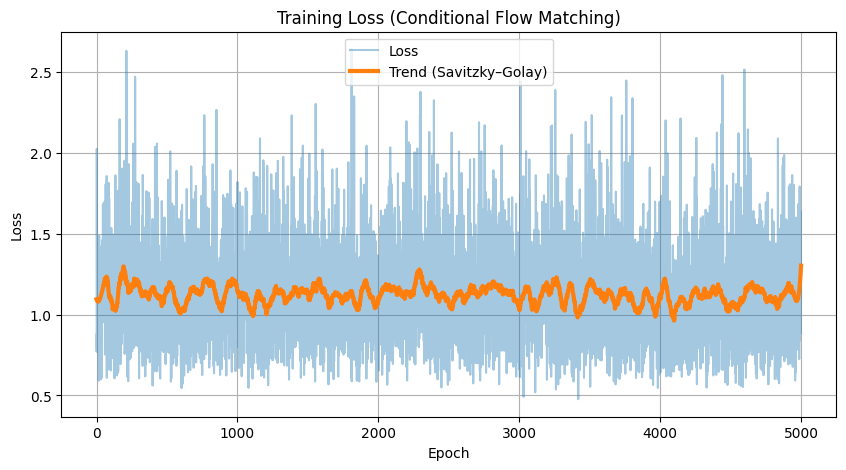

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# ---- Train ----
losses = trainer.train(
    num_epochs = 5000,
    device = device,
    lr = 3e-4,
    batch_size = 512
)

# ---- Savitzky–Golay smoother ----
trend = savgol_filter(losses, window_length=101, polyorder=3)

# ---- Plot ----
plt.figure(figsize=(10,5))
plt.plot(losses, label="Loss", alpha=0.4)
plt.plot(trend, label="Trend (Savitzky–Golay)", linewidth=3)
plt.title("Training Loss (Conditional Flow Matching)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


In [139]:
device = next(flow_model.parameters()).device

batch_size = 512
t = torch.rand(batch_size, 1, device=device)
t = 0.05 + 0.9 * t

z = path.sample_conditioning_variable(batch_size)
x_t = path.sample_conditional_path(z, t)

with torch.no_grad():
    u_star = path.conditional_vector_field(x_t, z, t)
    u_theta = flow_model(x_t, t)

mse = ((u_theta - u_star)**2).mean().item()
print("Post-training MSE between u_theta and u_star:", mse)


Post-training MSE between u_theta and u_star: 0.3551913797855377


In [104]:
class LearnedVectorFieldODE(ODE):
    def __init__(self, net: MLPVectorField):
        self.net = net

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: (bs, dim)
            - t: (bs, dim)
        Returns:
            - u_t: (bs, dim)
        """
        return self.net(x, t)

In [ ]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3


##############
# Setup Plot #
##############

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size=24
markerscale=1.8

# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))

###########################################
# Graph Samples from Learned Marginal ODE #
###########################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Samples from Learned Marginal ODE", fontsize=20)

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

##############################################
# Graph Trajectories of Learned Marginal ODE #
##############################################
ax = axes[2]
ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(num_samples // 10):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

################################################
# Graph Ground-Truth Marginal Probability Path #
################################################
ax = axes[0]
ax.set_title("Ground-Truth Marginal Probability Path", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    marginal_samples = path.sample_marginal_path(tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)
    
plt.show()